# MLP for Dataset Version 3 (Dimension Reduction) + Optimized Hyperparameter -- MLP 1

1. Import Necessary Libraries:

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt

2. Preparing Data:

In [3]:
data = pd.read_csv("DataVersion3.csv")

In [4]:
data.shape

(25794, 17)

In [5]:
data_reduced_dim = pd.read_csv("TruncatedSVD_50.csv", header = None)

In [6]:
data_reduced_dim.shape

(25794, 50)

In [7]:
# Split data into train, validation, and test sets
X = data_reduced_dim.values
y = data["price_in_billion"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [8]:
X.shape

(25794, 50)

In [10]:
data = np.load('data_splits_v8.npz')
train_indices = data['train_indices']
val_indices = data['val_indices']
test_indices = data['test_indices']

X_train = X[train_indices]
y_train = y[train_indices]
X_val = X[val_indices]
y_val = y[val_indices]
X_test = X[test_indices]
y_test = y[test_indices]


In [11]:
class CarDataset(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [12]:
train_dataset = CarDataset(X_train, y_train)
val_dataset = CarDataset(X_val, y_val)
test_dataset = CarDataset(X_test, y_test)

# Load the saved DataLoader objects
train_loader, val_loader, test_loader = torch.load(f'dataloaders_128.pt')

In [13]:
#MLP for regresion
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2: 
                layers.append(nn.ReLU())
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


In [21]:
layer_sizes = [50]

hidden_layer_sizes = [111, 122, 80] 
layer_sizes.extend(hidden_layer_sizes)

layer_sizes.append(1)

model = MLP(layer_sizes)

optimizer = optim.Adam(model.parameters(), lr = 0.0023340117186307907, weight_decay = 6.818751742897769e-05)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

MLP(
  (network): Sequential(
    (0): Linear(in_features=50, out_features=111, bias=True)
    (1): ReLU()
    (2): Linear(in_features=111, out_features=122, bias=True)
    (3): ReLU()
    (4): Linear(in_features=122, out_features=80, bias=True)
    (5): ReLU()
    (6): Linear(in_features=80, out_features=1, bias=True)
  )
)

Epoch [1/200], Loss: 0.5064, Val Loss: 0.9625
Epoch [2/200], Loss: 1.2800, Val Loss: 0.8433
Epoch [3/200], Loss: 0.2627, Val Loss: 0.7963
Epoch [4/200], Loss: 0.3663, Val Loss: 0.8137
Epoch [5/200], Loss: 0.3164, Val Loss: 0.8792
Epoch [6/200], Loss: 1.2186, Val Loss: 0.8183
Epoch [7/200], Loss: 0.1459, Val Loss: 0.6833
Epoch [8/200], Loss: 0.5811, Val Loss: 0.8773
Epoch [9/200], Loss: 0.1709, Val Loss: 0.7097
Epoch [10/200], Loss: 0.1037, Val Loss: 0.7094
Epoch [11/200], Loss: 2.0524, Val Loss: 0.7446
Epoch [12/200], Loss: 0.2566, Val Loss: 0.7770
Epoch [13/200], Loss: 0.1721, Val Loss: 0.6808
Epoch [14/200], Loss: 0.0632, Val Loss: 0.6457
Epoch [15/200], Loss: 0.5287, Val Loss: 0.7931
Epoch [16/200], Loss: 0.0624, Val Loss: 0.6438
Epoch [17/200], Loss: 0.2684, Val Loss: 0.6645
Epoch [18/200], Loss: 0.4475, Val Loss: 0.6224
Epoch [19/200], Loss: 0.2586, Val Loss: 0.6822
Epoch [20/200], Loss: 0.1123, Val Loss: 0.5757
Epoch [21/200], Loss: 0.2035, Val Loss: 0.6361
Epoch [22/200], Loss: 

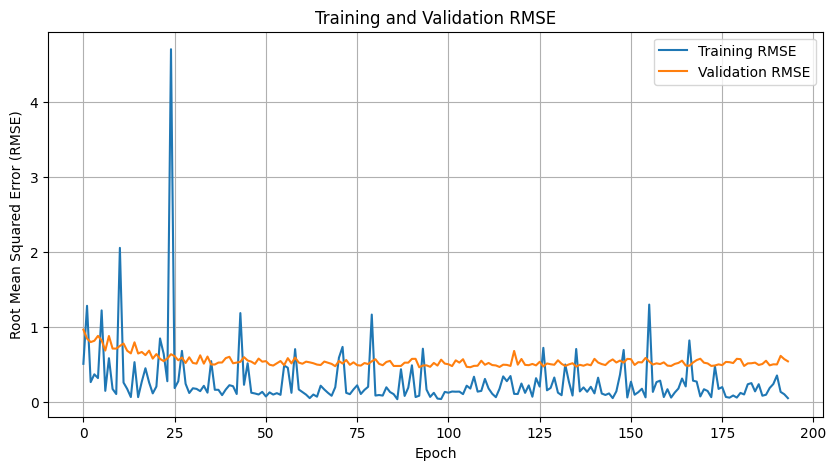

In [23]:
train_losses = []
val_losses = []

start_time = datetime.now()
# Training loop with early stopping
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 80
num_epochs = 200
with open("result.txt", "a") as f:
    f.write(f"Using optimizer: {optimizer.__class__.__name__}" + "\n")
    f.write("Standard data" + "\n")
    f.write("Optimized hyperparameter at Trial 299 finished with value: 0.2546721821831119 \
            and parameters: {'weight_decay': 6.818751742897769e-05, 'batch_size': 128, 'n_units_l1': 111, 'n_units_l2': 122, 'n_units_l3': 80}.\
            Suggested LR = 0.0023340117186307907" + '\n')
    f.write("TruncatedSVD_50" + '\n')
    f.write(f"MLP with layer size: {hidden_layer_sizes} - Result:\n")
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)  # Move data to the device
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
        val_loss /= len(val_loader)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        elif val_loss - best_val_loss < 0.005:
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f'Early stopping at epoch {epoch}')
                f.write(f'Early stopping at epoch {epoch}' + '\n')
                break
        train_losses.append(np.sqrt(loss.item())) # Store RMSE for training
        val_losses.append(np.sqrt(val_loss))       # Store RMSE for validation
        result = f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.sqrt(loss.item()):.4f}, Val Loss: {np.sqrt(val_loss):.4f}'
        print(result)
        f.write(result + "\n")
    running_time = datetime.now() - start_time
    print("Runtime: ", running_time)
    f.write(f"Runtime: {running_time}" + '\n')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training RMSE')
plt.plot(val_losses, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
all_preds = np.empty((0, 1))
all_targets = np.empty((0, 1))
with open("result.txt", "a") as f:
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            all_preds = np.vstack((all_preds, outputs.cpu().numpy()))
            all_targets = np.vstack((all_targets, targets.cpu().numpy()))
    
    # Flatten arrays to 1D
    all_preds = all_preds.flatten()
    all_targets = all_targets.flatten()

    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)
    mape = np.mean(np.abs((all_targets - all_preds) / all_targets)) * 100
    
    print(f'R^2 Score: {r2:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'MAPE: {mape:.2f}%')

    f.write(f'R^2 Score: {r2:.4f}' + '\n')
    f.write(f'RMSE: {rmse:.4f}' + '\n')
    f.write(f'MAE: {mae:.4f}' + '\n')
    f.write(f'MAPE: {mape:.2f}%' + '\n')

R^2 Score: 0.9087
RMSE: 0.5919
MAE: 0.1852
MAPE: 15.09%


In [25]:
save_path = './mlp_Optimized_Hyper.pth'
torch.save(model.state_dict(), save_path)

# MLP Applied Double Descent Phenomenon -- MLP 2

1. Import Necessary Libraries:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt

2. Preparing Data:

In [2]:
data = pd.read_csv("DataVersion3.csv")

In [3]:
data.shape

(25794, 17)

In [4]:
data_reduced_dim = pd.read_csv("TruncatedSVD_50.csv", header = None)

In [5]:
data_reduced_dim.shape

(25794, 50)

In [6]:
# Split data into train, validation, and test sets
X = data_reduced_dim.values
y = data["price_in_billion"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
X.shape

(25794, 50)

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [9]:
class CarDataset(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
train_dataset = CarDataset(X_train, y_train)
val_dataset = CarDataset(X_val, y_val)
test_dataset = CarDataset(X_test, y_test)

BATCH_SIZE = 512
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [11]:
#MLP for regresion
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2: 
                layers.append(nn.ReLU())
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


In [12]:
layer_sizes = [50]

hidden_layer_sizes = [222, 900, 1384, 1024, 160] 
layer_sizes.extend(hidden_layer_sizes)

layer_sizes.append(1)

model = MLP(layer_sizes)

optimizer = optim.Adam(model.parameters(), lr = 0.0023340117186307907, weight_decay = 0.001)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

MLP(
  (network): Sequential(
    (0): Linear(in_features=50, out_features=222, bias=True)
    (1): ReLU()
    (2): Linear(in_features=222, out_features=900, bias=True)
    (3): ReLU()
    (4): Linear(in_features=900, out_features=1384, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1384, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=160, bias=True)
    (9): ReLU()
    (10): Linear(in_features=160, out_features=1, bias=True)
  )
)

Epoch [1/1000], Loss: 0.9296, Val Loss: 0.9279
Epoch [2/1000], Loss: 0.6447, Val Loss: 0.8081
Epoch [3/1000], Loss: 0.9035, Val Loss: 0.8304
Epoch [4/1000], Loss: 0.6826, Val Loss: 0.9356
Epoch [5/1000], Loss: 0.6236, Val Loss: 0.7351
Epoch [6/1000], Loss: 0.6168, Val Loss: 0.7843
Epoch [7/1000], Loss: 1.0265, Val Loss: 0.7002
Epoch [8/1000], Loss: 0.9246, Val Loss: 0.8649
Epoch [9/1000], Loss: 0.6706, Val Loss: 0.6899
Epoch [10/1000], Loss: 0.3610, Val Loss: 0.7101
Epoch [11/1000], Loss: 0.3835, Val Loss: 0.6244
Epoch [12/1000], Loss: 0.5238, Val Loss: 0.7298
Epoch [13/1000], Loss: 0.5475, Val Loss: 0.6418
Epoch [14/1000], Loss: 0.4720, Val Loss: 0.6819
Epoch [15/1000], Loss: 0.4393, Val Loss: 0.6437
Epoch [16/1000], Loss: 0.6660, Val Loss: 0.6821
Epoch [17/1000], Loss: 0.4465, Val Loss: 0.6772
Epoch [18/1000], Loss: 0.5599, Val Loss: 0.5533
Epoch [19/1000], Loss: 0.7710, Val Loss: 0.6158
Epoch [20/1000], Loss: 0.3707, Val Loss: 0.5881
Epoch [21/1000], Loss: 0.4529, Val Loss: 0.7308
E

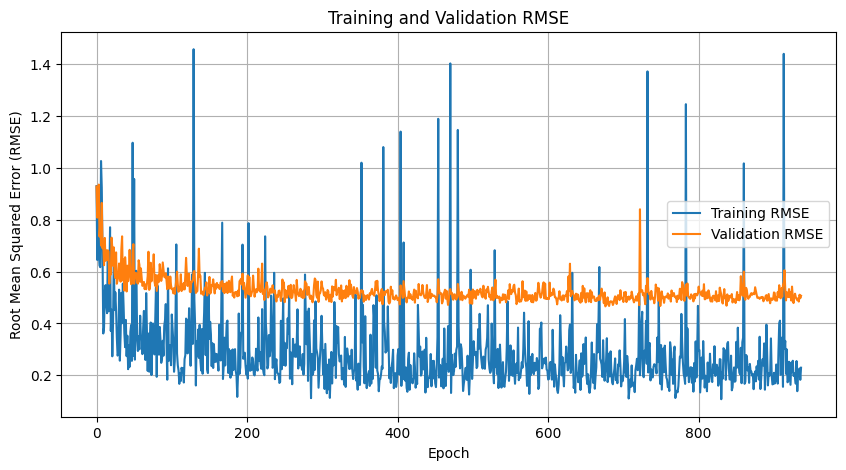

In [14]:
train_losses = []
val_losses = []

start_time = datetime.now()
# Training loop with early stopping
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 100
num_epochs = 1000
with open("result.txt", "a") as f:
    f.write(f"Using optimizer: {optimizer.__class__.__name__}" + "\n")
    f.write("TruncatedSVD_50" + '\n')
    f.write(f"MLP with layer size: {hidden_layer_sizes} - Result:\n")
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)  # Move data to the device
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
        val_loss /= len(val_loader)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        elif val_loss - best_val_loss < 0.005:
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f'Early stopping at epoch {epoch}')
                f.write(f'Early stopping at epoch {epoch}' + '\n')
                break
        train_losses.append(np.sqrt(loss.item())) # Store RMSE for training
        val_losses.append(np.sqrt(val_loss))       # Store RMSE for validation
        result = f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.sqrt(loss.item()):.4f}, Val Loss: {np.sqrt(val_loss):.4f}'
        print(result)
        f.write(result + "\n")
    running_time = datetime.now() - start_time
    print("Runtime: ", running_time)
    f.write(f"Runtime: {running_time}" + '\n')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training RMSE')
plt.plot(val_losses, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
all_preds = np.empty((0, 1))
all_targets = np.empty((0, 1))
with open("result.txt", "a") as f:
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            all_preds = np.vstack((all_preds, outputs.cpu().numpy()))
            all_targets = np.vstack((all_targets, targets.cpu().numpy()))
    
    # Flatten arrays to 1D
    all_preds = all_preds.flatten()
    all_targets = all_targets.flatten()

    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)
    mape = np.mean(np.abs((all_targets - all_preds) / all_targets)) * 100
    
    print(f'R^2 Score: {r2:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'MAPE: {mape:.2f}%')

    f.write(f'R^2 Score: {r2:.4f}' + '\n')
    f.write(f'RMSE: {rmse:.4f}' + '\n')
    f.write(f'MAE: {mae:.4f}' + '\n')
    f.write(f'MAPE: {mape:.2f}%' + '\n')

R^2 Score: 0.9131
RMSE: 0.6675
MAE: 0.1836
MAPE: 16.37%


In [85]:
save_path = './mlp_Double_Descent.pth'
torch.save(model.state_dict(), save_path)

# MLP for Dataset Version 3 (Dimension Reduction) + Optimized Hyperparameter + PSO Initialization -- MLP 3

1. Import Necessary Libraries:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import optuna
from fastai.learner import Learner
from fastai.data.core import DataLoaders
from fastai.callback.schedule import lr_find
from fastai.optimizer import Adam

2. Preparing Data:

In [521]:
data = pd.read_csv("DataVersion3.csv")

In [522]:
data.shape

(25794, 17)

In [523]:
data_reduced_dim = pd.read_csv("TruncatedSVD_50.csv", header = None)

In [524]:
data_reduced_dim.shape

(25794, 50)

In [525]:
# Split data into train, validation, and test sets
X = data_reduced_dim.values
y = data["price_in_billion"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [526]:
X.shape

(25794, 50)

In [86]:
data = np.load('data_splits_v8.npz')
train_indices = data['train_indices']
val_indices = data['val_indices']
test_indices = data['test_indices']

X_train = X[train_indices]
y_train = y[train_indices]
X_val = X[val_indices]
y_val = y[val_indices]
X_test = X[test_indices]
y_test = y[test_indices]


In [87]:
class CarDataset(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [131]:
train_dataset = CarDataset(X_train, y_train)
val_dataset = CarDataset(X_val, y_val)
test_dataset = CarDataset(X_test, y_test)

# Load the saved DataLoader objects
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [89]:
#MLP for regresion
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2: 
                layers.append(nn.ReLU())
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


In [128]:
layer_sizes = [50]

hidden_layer_sizes = [49, 61, 61] 
layer_sizes.extend(hidden_layer_sizes)

layer_sizes.append(1)

model = MLP(layer_sizes)

optimizer = optim.Adam(model.parameters(), lr = 0.00038980599492788315, weight_decay = 8.0533892993599144e-04)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression

In [129]:
model.load_state_dict(torch.load(r"D:\fpt47\Downloads\Programming\Code\2023.2\ML\Mid-term Project\DataProcessing\Swarm Optimization\PSO_StandardData_mlp_model.pth"))

<All keys matched successfully>

In [130]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

MLP(
  (network): Sequential(
    (0): Linear(in_features=50, out_features=49, bias=True)
    (1): ReLU()
    (2): Linear(in_features=49, out_features=61, bias=True)
    (3): ReLU()
    (4): Linear(in_features=61, out_features=61, bias=True)
    (5): ReLU()
    (6): Linear(in_features=61, out_features=1, bias=True)
  )
)

Epoch [1/150], Loss: 1.0273, Val Loss: 0.8059
Epoch [2/150], Loss: 0.7466, Val Loss: 0.7761
Epoch [3/150], Loss: 0.6056, Val Loss: 0.7754
Epoch [4/150], Loss: 0.4176, Val Loss: 0.7533
Epoch [5/150], Loss: 0.5432, Val Loss: 0.9163
Epoch [6/150], Loss: 0.6954, Val Loss: 0.7687
Epoch [7/150], Loss: 0.3644, Val Loss: 1.0079
Epoch [8/150], Loss: 0.6269, Val Loss: 0.7510
Epoch [9/150], Loss: 0.6404, Val Loss: 0.7118
Epoch [10/150], Loss: 0.9842, Val Loss: 0.7002
Epoch [11/150], Loss: 0.8705, Val Loss: 0.7106
Epoch [12/150], Loss: 0.7001, Val Loss: 0.7217
Epoch [13/150], Loss: 0.8184, Val Loss: 0.7160
Epoch [14/150], Loss: 0.4718, Val Loss: 0.7887
Epoch [15/150], Loss: 0.5613, Val Loss: 0.7311
Epoch [16/150], Loss: 0.5306, Val Loss: 0.7326
Epoch [17/150], Loss: 0.9356, Val Loss: 0.6911
Epoch [18/150], Loss: 0.5728, Val Loss: 0.6979
Epoch [19/150], Loss: 0.5359, Val Loss: 0.7205
Epoch [20/150], Loss: 1.5826, Val Loss: 0.6946
Epoch [21/150], Loss: 0.3545, Val Loss: 0.7173
Epoch [22/150], Loss: 

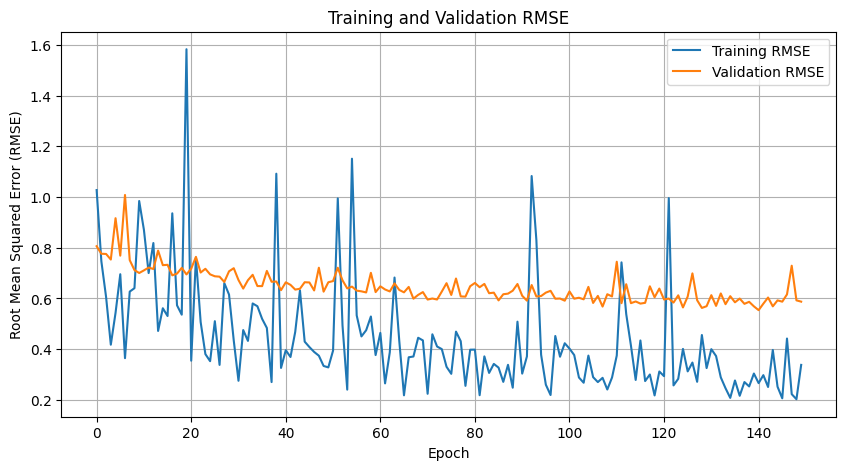

In [132]:
train_losses = []
val_losses = []

start_time = datetime.now()
# Training loop with early stopping
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 50
num_epochs = 250
with open("result.txt", "a") as f:
    f.write(f"Using optimizer: {optimizer.__class__.__name__}" + "\n")
    f.write("With PSO (1470 iter) initialization")
    f.write("Standard data" + "\n")
    f.write("TruncatedSVD_50" + '\n')
    f.write(f"MLP with layer size: {hidden_layer_sizes} - Result:\n")
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)  # Move data to the device
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
        val_loss /= len(val_loader)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        elif val_loss - best_val_loss < 0.005:
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f'Early stopping at epoch {epoch}')
                f.write(f'Early stopping at epoch {epoch}' + '\n')
                break
        train_losses.append(np.sqrt(loss.item())) # Store RMSE for training
        val_losses.append(np.sqrt(val_loss))       # Store RMSE for validation
        result = f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.sqrt(loss.item()):.4f}, Val Loss: {np.sqrt(val_loss):.4f}'
        print(result)
        f.write(result + "\n")
    running_time = datetime.now() - start_time
    print("Runtime: ", running_time)
    f.write(f"Runtime: {running_time}" + '\n')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training RMSE')
plt.plot(val_losses, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [134]:
all_preds = np.empty((0, 1))
all_targets = np.empty((0, 1))
with open("result.txt", "a") as f:
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            all_preds = np.vstack((all_preds, outputs.cpu().numpy()))
            all_targets = np.vstack((all_targets, targets.cpu().numpy()))
    
    # Flatten arrays to 1D
    all_preds = all_preds.flatten()
    all_targets = all_targets.flatten()

    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)
    mape = np.mean(np.abs((all_targets - all_preds) / all_targets)) * 100
    
    print(f'R^2 Score: {r2:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'MAPE: {mape:.2f}%')

    f.write(f'R^2 Score: {r2:.4f}' + '\n')
    f.write(f'RMSE: {rmse:.4f}' + '\n')
    f.write(f'MAE: {mae:.4f}' + '\n')
    f.write(f'MAPE: {mape:.2f}%' + '\n')

R^2 Score: 0.8923
RMSE: 0.7544
MAE: 0.2420
MAPE: 20.93%


In [190]:
save_path = './mlp_PSO_init.pth'
torch.save(model.state_dict(), save_path)

# MLP for Dataset Version 3 (Dimension Reduction)

1. Import Necessary Libraries:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt

2. Preparing Data:

In [ ]:
data = pd.read_csv("DataVersion3.csv")

In [ ]:
data.shape

(25794, 17)

In [ ]:
data_reduced_dim = pd.read_csv("TruncatedSVD_50.csv", header = None)

In [ ]:
data_reduced_dim.shape

(25794, 50)

In [ ]:
# Split data into train, validation, and test sets
X = data_reduced_dim.values
y = data["price_in_billion"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
X.shape

(25794, 50)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
class CarDataset(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
train_dataset = CarDataset(X_train, y_train)
val_dataset = CarDataset(X_val, y_val)
test_dataset = CarDataset(X_test, y_test)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
#MLP for regresion
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2: 
                layers.append(nn.ReLU())
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


In [ ]:
layer_sizes = [50]

hidden_layer_sizes = [41, 20, 10] 
layer_sizes.extend(hidden_layer_sizes)

layer_sizes.append(1)

model = MLP(layer_sizes)

optimizer = optim.Adam(model.parameters(), lr = 1.31E-02, weight_decay = 3.5914427054784434E-06)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Epoch [1/100], Loss: 0.6599, Val Loss: 1.0723
Epoch [2/100], Loss: 2.9149, Val Loss: 1.2277
Epoch [3/100], Loss: 0.3572, Val Loss: 1.6916
Epoch [4/100], Loss: 0.3284, Val Loss: 1.0138
Epoch [5/100], Loss: 0.4728, Val Loss: 0.9635
Epoch [6/100], Loss: 0.4321, Val Loss: 0.8926
Epoch [7/100], Loss: 0.3551, Val Loss: 0.9365
Epoch [8/100], Loss: 1.3102, Val Loss: 1.0946
Epoch [9/100], Loss: 0.4954, Val Loss: 0.9616
Epoch [10/100], Loss: 0.3973, Val Loss: 1.0002
Epoch [11/100], Loss: 0.5532, Val Loss: 1.3279
Epoch [12/100], Loss: 0.6307, Val Loss: 1.0773
Epoch [13/100], Loss: 0.2868, Val Loss: 0.9915
Epoch [14/100], Loss: 0.4279, Val Loss: 1.0154
Epoch [15/100], Loss: 0.2136, Val Loss: 1.0298
Epoch [16/100], Loss: 0.6174, Val Loss: 1.3667
Epoch [17/100], Loss: 0.3522, Val Loss: 0.8775
Epoch [18/100], Loss: 0.3438, Val Loss: 1.0024
Epoch [19/100], Loss: 0.4892, Val Loss: 0.9438
Epoch [20/100], Loss: 1.9821, Val Loss: 0.8944
Epoch [21/100], Loss: 0.3451, Val Loss: 1.4496
Epoch [22/100], Loss: 

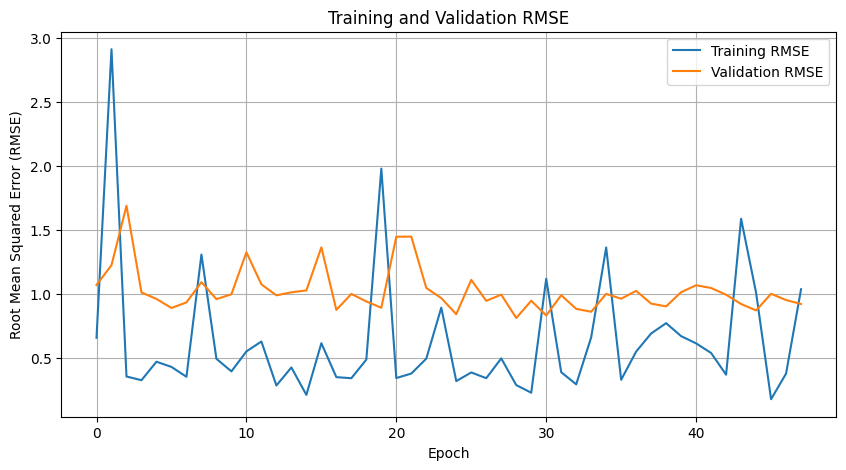

In [ ]:
train_losses = []
val_losses = []

start_time = datetime.now()
# Training loop with early stopping
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 20
num_epochs = 100
with open("result.txt", "a") as f:
    f.write("TruncatedSVD_50" + '\n')
    f.write(f"MLP with layer size: {hidden_layer_sizes} - Result:\n")
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)  # Move data to the device
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
        val_loss /= len(val_loader)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        elif val_loss - best_val_loss < 0.005:
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f'Early stopping at epoch {epoch}')
                f.write(f'Early stopping at epoch {epoch}' + '\n')
                break
        train_losses.append(np.sqrt(loss.item())) # Store RMSE for training
        val_losses.append(np.sqrt(val_loss))       # Store RMSE for validation
        result = f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.sqrt(loss.item()):.4f}, Val Loss: {np.sqrt(val_loss):.4f}'
        print(result)
        f.write(result + "\n")
    running_time = datetime.now() - start_time
    print("Runtime: ", running_time)
    f.write(f"Runtime: {running_time}" + '\n')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training RMSE')
plt.plot(val_losses, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
all_preds = np.empty((0, 1))
all_targets = np.empty((0, 1))
with open("result.txt", "a") as f:
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            all_preds = np.vstack((all_preds, outputs.cpu().numpy()))
            all_targets = np.vstack((all_targets, targets.cpu().numpy()))
    
    # Flatten arrays to 1D
    all_preds = all_preds.flatten()
    all_targets = all_targets.flatten()

    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)
    mape = np.mean(np.abs((all_targets - all_preds) / all_targets)) * 100
    
    print(f'R^2 Score: {r2:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'MAPE: {mape:.2f}%')

    f.write(f'R^2 Score: {r2:.4f}' + '\n')
    f.write(f'RMSE: {rmse:.4f}' + '\n')
    f.write(f'MAE: {mae:.4f}' + '\n')
    f.write(f'MAPE: {mape:.2f}%' + '\n')

R^2 Score: 0.6735
RMSE: 1.2938
MAE: 0.5091
MAPE: 74.63%


# MLP for Dataset Version 3 (Dimension Reduction) + Dropout

1. Import Necessary Libraries:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
from torch_lr_finder import LRFinder
import optuna

2. Preparing Data:

In [ ]:
data = pd.read_csv("DataVersion3.csv")

In [ ]:
data.shape

(25794, 17)

In [ ]:
data_reduced_dim = pd.read_csv("TruncatedSVD_50.csv", header = None)

In [ ]:
data_reduced_dim.shape

(25794, 50)

In [ ]:
# Split data into train, validation, and test sets
X = data_reduced_dim.values
y = data["price_in_billion"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
X.shape

(25794, 50)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
class CarDataset(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
train_dataset = CarDataset(X_train, y_train)
val_dataset = CarDataset(X_val, y_val)
test_dataset = CarDataset(X_test, y_test)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
#MLP for regresion
class MLP(nn.Module):
    def __init__(self, layer_sizes, dropout_prob=0.2):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2: 
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout_prob))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


In [ ]:
layer_sizes = [X_train.shape[1]]

hidden_layer_sizes = [128, 64, 32] 
layer_sizes.extend(hidden_layer_sizes)

layer_sizes.append(1)

model = MLP(layer_sizes, dropout_prob=0.3)

optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.001)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

MLP(
  (network): Sequential(
    (0): Linear(in_features=50, out_features=111, bias=True)
    (1): ReLU()
    (2): Linear(in_features=111, out_features=122, bias=True)
    (3): ReLU()
    (4): Linear(in_features=122, out_features=80, bias=True)
    (5): ReLU()
    (6): Linear(in_features=80, out_features=1, bias=True)
  )
)

4. Training model

Epoch [1/100], Loss: 0.7387, Val Loss: 0.9946
Epoch [2/100], Loss: 1.8051, Val Loss: 0.8910
Epoch [3/100], Loss: 0.1557, Val Loss: 0.8396
Epoch [4/100], Loss: 0.4474, Val Loss: 0.8400
Epoch [5/100], Loss: 0.1310, Val Loss: 0.8063
Epoch [6/100], Loss: 3.0578, Val Loss: 0.7542
Epoch [7/100], Loss: 0.8720, Val Loss: 0.7790
Epoch [8/100], Loss: 0.3851, Val Loss: 0.8086
Epoch [9/100], Loss: 0.4185, Val Loss: 0.7680
Epoch [10/100], Loss: 0.5160, Val Loss: 0.7862
Epoch [11/100], Loss: 0.1758, Val Loss: 0.8756
Epoch [12/100], Loss: 0.1671, Val Loss: 0.7369
Epoch [13/100], Loss: 0.2648, Val Loss: 0.7752
Epoch [14/100], Loss: 0.1567, Val Loss: 0.7446
Epoch [15/100], Loss: 0.4342, Val Loss: 0.7537
Epoch [16/100], Loss: 0.1589, Val Loss: 0.7996
Epoch [17/100], Loss: 0.2299, Val Loss: 0.7126
Epoch [18/100], Loss: 0.2648, Val Loss: 0.7233
Epoch [19/100], Loss: 0.6384, Val Loss: 0.9160
Epoch [20/100], Loss: 0.3341, Val Loss: 0.7151
Epoch [21/100], Loss: 0.3183, Val Loss: 0.7253
Epoch [22/100], Loss: 

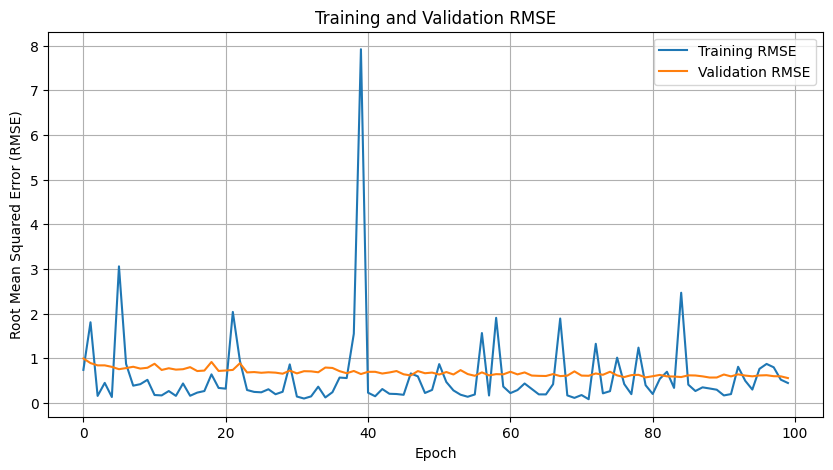

In [ ]:
train_losses = []
val_losses = []

start_time = datetime.now()
# Training loop with early stopping
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 20
num_epochs = 100
with open("result.txt", "a") as f:
    f.write("TruncatedSVD_50" + '\n')
    f.write(f"MLP with layer size: {hidden_layer_sizes} - Result:\n")
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)  # Move data to the device
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
        val_loss /= len(val_loader)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        elif val_loss - best_val_loss < 0.005:
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f'Early stopping at epoch {epoch}')
                f.write(f'Early stopping at epoch {epoch}' + '\n')
                break
        train_losses.append(np.sqrt(loss.item())) # Store RMSE for training
        val_losses.append(np.sqrt(val_loss))       # Store RMSE for validation
        result = f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.sqrt(loss.item()):.4f}, Val Loss: {np.sqrt(val_loss):.4f}'
        print(result)
        f.write(result + "\n")
    running_time = datetime.now() - start_time
    print("Runtime: ", running_time)
    f.write(f"Runtime: {running_time}" + '\n')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training RMSE')
plt.plot(val_losses, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
all_preds = np.empty((0, 1))
all_targets = np.empty((0, 1))
with open("result.txt", "a") as f:
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            all_preds = np.vstack((all_preds, outputs.cpu().numpy()))
            all_targets = np.vstack((all_targets, targets.cpu().numpy()))
    
    # Flatten arrays to 1D
    all_preds = all_preds.flatten()
    all_targets = all_targets.flatten()

    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)
    mape = np.mean(np.abs((all_targets - all_preds) / all_targets)) * 100
    
    print(f'R^2 Score: {r2:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'MAPE: {mape:.2f}%')

    f.write(f'R^2 Score: {r2:.4f}' + '\n')
    f.write(f'RMSE: {rmse:.4f}' + '\n')
    f.write(f'MAE: {mae:.4f}' + '\n')
    f.write(f'MAPE: {mape:.2f}%' + '\n')

R^2 Score: 0.8759
RMSE: 0.7978
MAE: 0.2297
MAPE: 22.31%
